# Importing Necessary Directories



In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import RidgeClassifier


# **Extracting Data from Kaggle**

I created a Kaggle API Token and uploaded the .json file to my Google Drive. A hidden directory was created to store the .json file for authentication. Afterwards, I directly loaded the **Winconsin Breast Cancer Dataset** to my environment.

In [2]:
! pip install kaggle

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
! mkdir ~/.kaggle

In [5]:
! cp //content/drive/MyDrive/Kaggle_API/kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle datasets download uciml/breast-cancer-wisconsin-data

Dataset URL: https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data
License(s): CC-BY-NC-SA-4.0
  0% 0.00/48.6k [00:00<?, ?B/s]
100% 48.6k/48.6k [00:00<00:00, 143MB/s]


In [8]:
! unzip -o breast-cancer-wisconsin-data.zip

Archive:  breast-cancer-wisconsin-data.zip
  inflating: data.csv                


# Data Description


In [9]:
df = pd.read_csv('/content/data.csv')

In [10]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


The **Breast Cancer Wisconsin (Diagnostic) Data Set** has **10 real-valued features** of medical examinations of breasts along with an outcome of Malignant or Benign, referring to presence or absence of cancel cells respectively.

The **mean**, **standard error** and **"worst" or largest** (mean of the three
largest values) of these features were computed for each image,
resulting in 30 features.

# Data Cleaning

**Steps Taken:**

1.   Checked for duplicate rows of data; *found none.*
2.   Dropped 'id' and 'diagnosis from the dependent variables. 'id' was irrelevant as an input variable and 'diagnosis' was the **target variable**.
3. Performed Binary label encoding of categorical target values. 'Malignant' was encoded as 1, "Benign' as 0.



In [11]:
duplicate_rows = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

Number of duplicate rows: 0


In [12]:
X = df.drop(['id', 'diagnosis', 'Unnamed: 32'], axis=1)
y = df['diagnosis'].map({'M': 1, 'B': 0})

# Ridge Classifer

**Ridge Classifier:** a linear classification model that applies Ridge Regression (with L2 regularization) to a classification problem.

A Ridge Regression minimizes:

**Loss=∣∣y−Xw∣∣^2+α∣∣w∣∣^2**

Where,

𝑋: input features

𝑦: target values (here, class labels converted to +1 and -1)

𝑤: model weights

α: regularization strength (controls how much penalty is added to large weights)


# Judging Suitability of the Data for Ridge Classification

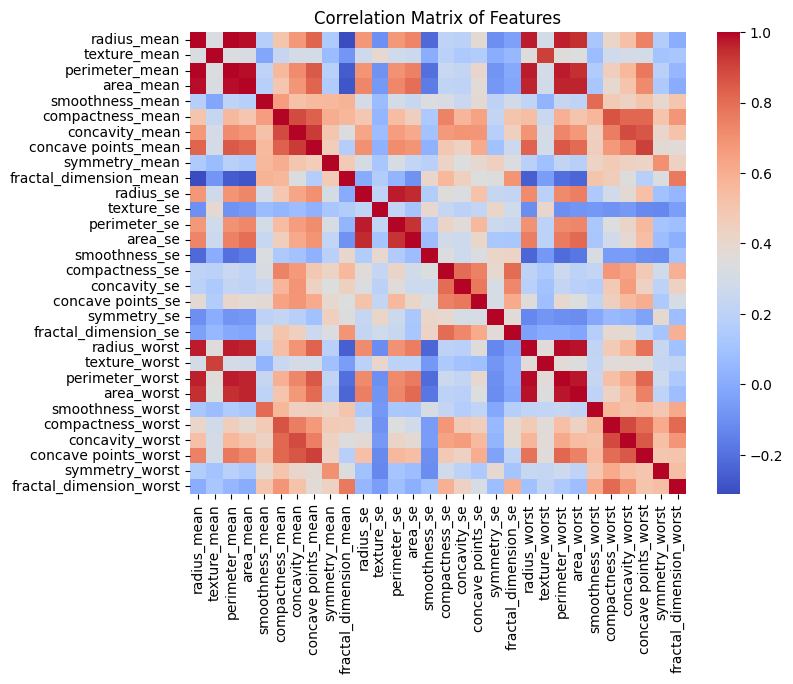

In [13]:
correlation_matrix = X.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()

**Observation: Possible High Cases of Collinearity**



**Calculating Variance Inflation Factor (VIF)**

In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Add a constant to the dataframe to calculate VIF for the intercept
X_with_constant = X.copy()
X_with_constant['intercept'] = 1

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X_with_constant.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_constant.values, i)
                   for i in range(X_with_constant.shape[1])]

# Display the VIF data
print("Top 5 features with highest VIF:")
display(vif_data.sort_values(by="VIF", ascending=False).head(5))

Top 5 features with highest VIF:


,feature,VIF
0,radius_mean,3806.115296
2,perimeter_mean,3786.400419
30,intercept,1868.188844
20,radius_worst,799.105946
22,perimeter_worst,405.023336


**A feature is determined as having collinearity when the VIF is higher than 5.Having so many features with extremely high VIF confirms high collinearity in the data**

**Final Verdict:**

Numerical Features with high collinearity. Hence, **Ridge Classifier is ideal** as it minimizes overfitting the data by ensuring the model doesn't give imbalanced significance to any specific feature.


# Data Splitting & Scaling

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Split:** I am doing a standard 80-20 split for training and testing.

**Scaler:** I am using StandardScaler to ensure that the difference in magnitude among the different factors does not skew the model.

# Model Training

In [16]:
# Training the Model
model = RidgeClassifier(class_weight='balanced', alpha = 10)
model.fit(X_train_scaled, y_train)

RidgeClassifier(alpha=10, class_weight='balanced')

**Class_weight ='balanced' :** The number of Benign cases is higher than Malignant ones in the data. A balanced claas_weight ensures equitable treatment of all data instances by putting a commensurately higher penalty on errors on the minority class. This leads to higher F1-scores for the model by optimizing Precision and Recall.

# Accuracy

In [17]:
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9736842105263158


This means that **out of 100 predictions made, over 97 are correct.**

However, we must dig deeper with Precision, Recall and F-1 score to ensure that we can correctly predict both Benign and Malignant cases.

# Overall Report

In [20]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98        71
           1       0.98      0.95      0.96        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



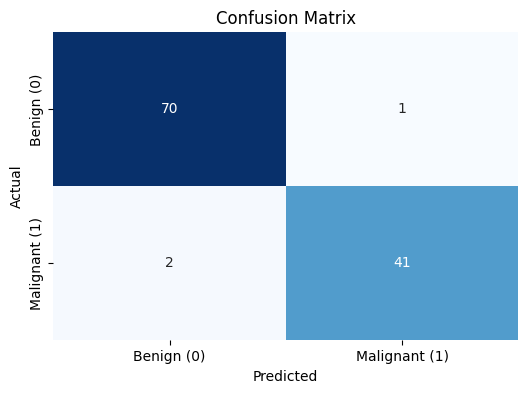

In [21]:
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Benign (0)', 'Malignant (1)'],
            yticklabels=['Benign (0)', 'Malignant (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

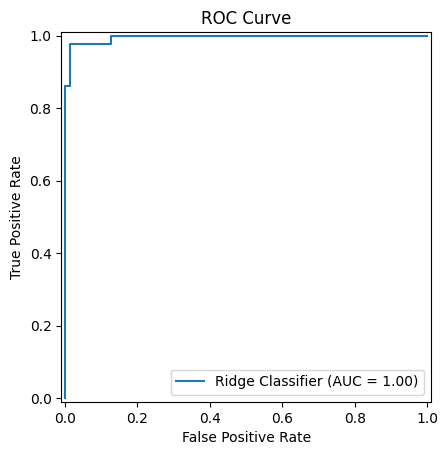

AUC: 0.9954143465443825


In [22]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay


# RidgeClassifier does not have predict_proba, so I will use decision_function
y_score = model.decision_function(X_test_scaled)

# Calculating the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Ridge Classifier')
display.plot()
plt.title('ROC Curve')
plt.show()

print(f"AUC: {roc_auc}")

# Most Important Factors

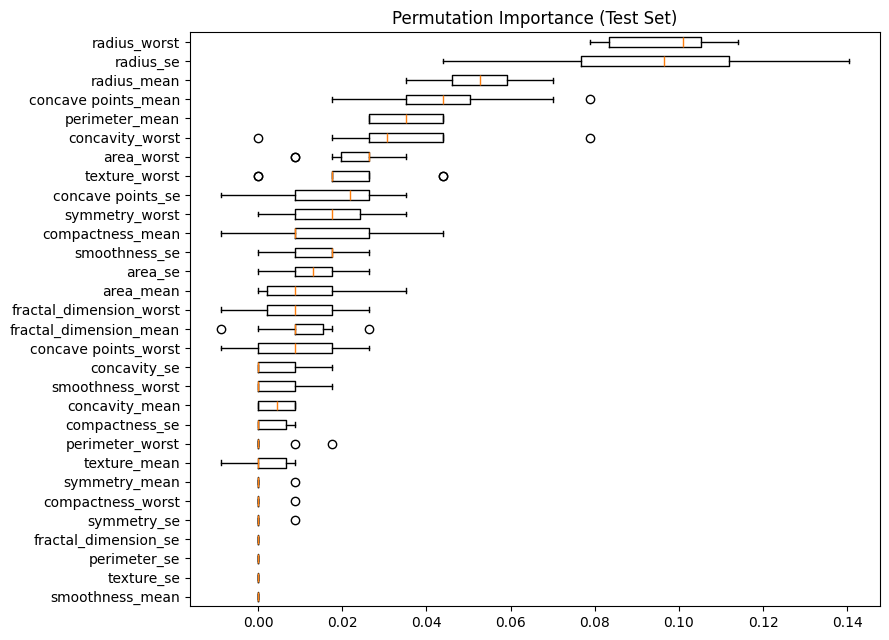

In [23]:
from sklearn.inspection import permutation_importance

result = permutation_importance(model, X_test_scaled, y_test, n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(9, 6.5))
plt.boxplot(result.importances[sorted_idx].T, vert=False, tick_labels=X.columns[sorted_idx])
plt.title("Permutation Importance (Test Set)")
plt.tight_layout()
plt.show()

The permutation_importance function helps us to determine the most important factors. For each feature, it shuffles its values in X_test_scaled (while keeping others fixed), predicts with the model, and computes the drop in score (default: accuracy for classifiers) compared to the baseline.

# Tinkering the Alpha

In [24]:
from sklearn.model_selection import GridSearchCV

param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0]}
grid_search = GridSearchCV(RidgeClassifier(class_weight='balanced'), param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Best parameters: {'alpha': 10.0}
Best cross-validation score: 0.9714285714285713
